In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
clean_data = pd.read_excel('1a_out_FRGS_MedWastage_cleaned_noNA_class.xlsx')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
clean_data.shape

(734, 20)

cont
* age
* duration
* disease total counts
* bmqs

binary
* gender (not ordinal)
* diseases (ordinal)
* outcome (target)

ordinal
* education
* income

nominal
* state
* ethnicity
* marital

# Data Cleaning

In [4]:
clean_data.columns

Index(['ID', 'age', 'gender', 'ethnicity', 'marital_status', 'education',
       'state', 'income', 'durationYr_medIntake', 'disease_diabetic',
       'disease_hypertension', 'disease_cholesterol', 'disease_other',
       'disease_totalCounts', 'BMQ_TN', 'BMQ_TC', 'BMQ_TO', 'BMQ_TH',
       'outcome_RADIUM_score', 'outcome_RADIUM_class'],
      dtype='object')

In [5]:
categorical = ['gender','disease_diabetic','disease_hypertension','disease_cholesterol','disease_other','outcome_RADIUM_class']
nominal_columns = ['state','marital_status','ethnicity']
continuous_columns = ['age','durationYr_medIntake','disease_totalCounts','BMQ_TN','BMQ_TC','BMQ_TO','BMQ_TH']

In [6]:
#dropping score
clean_data = clean_data.drop('outcome_RADIUM_score',axis=1)


In [7]:
#ordinal mapping for income ranges
income_map = {'<1000':0, '1000-2000':1, '2001-3000': 2, '3001-4000':3, '4001-5000':4, '>5000':5}
clean_data['income'] = clean_data['income'].map(income_map)

ordinal_encoding_mapping = {
    'income':income_map
}

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clean_data['outcome_RADIUM_class'] = le.fit_transform(clean_data['outcome_RADIUM_class'])

## Outlier

In [9]:
#removing the outliers
from scipy.stats import zscore

#compute z-scores for continuous colums in clean_data
z_scores = zscore(clean_data[continuous_columns])
#check if all z-scores are within -3 to +3 range (no outliers)
outlier = (np.abs(z_scores)<4).all(axis=1)
clean_data_before = len(clean_data)
#filter rows in clean_data where all z-scores are within -3 to +3 range
clean_data = clean_data[outlier]
num_of_outliers = clean_data_before - len(clean_data)
print(f'Number of outlier removed: {num_of_outliers}')

Number of outlier removed: 8


In [10]:
#log transformation the outlier
#for column in continuous_columns:
#  clean_data[column] = np.log1p(clean_data[column])

# EDA

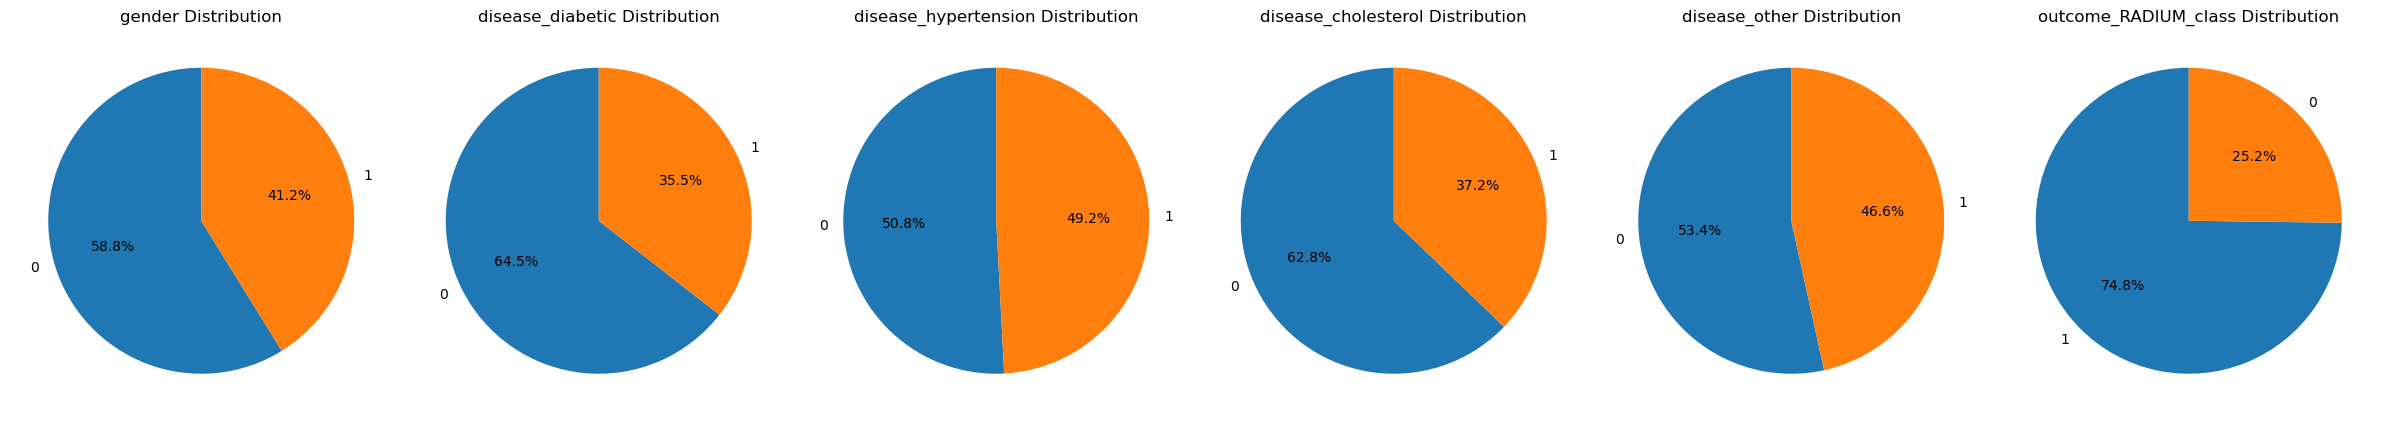

In [11]:

# Create subplots for each categorical variable
fig, axes = plt.subplots(nrows=1, ncols=len(categorical), figsize=(24, 6))

# Iterate through categorical variables and create pie charts
for i, category in enumerate(categorical):
    # Count unique values
    value_counts = clean_data[category].value_counts()
    
    # Plot pie chart for the current categorical variable
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{category} Distribution')

plt.tight_layout()  # Ensures that the subplots do not overlap
plt.show()


# Data splitting

In [12]:
X = clean_data.iloc[:,:-1]
y = clean_data['outcome_RADIUM_class']

In [13]:
#split with stratify to make sure each of them have equal size of target class
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=10,stratify=y)

In [14]:
X_train.shape

(544, 18)

# Preprocessing

In [15]:
#X_train = X_train.drop('ID',axis=1)
#X_test = X_test.drop('ID',axis=1)

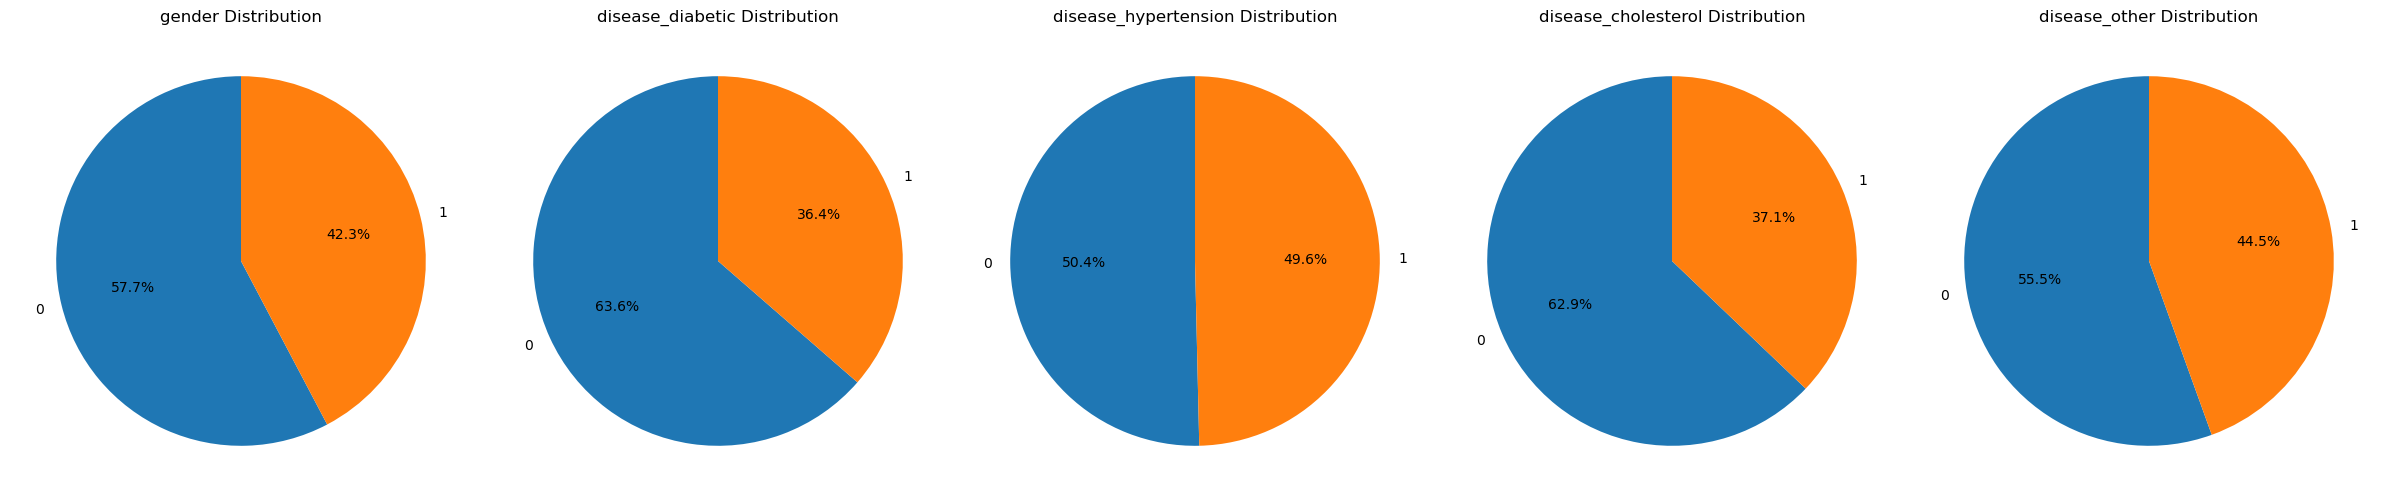

In [16]:
categorical.remove('outcome_RADIUM_class')
# Create subplots for each categorical variable
fig, axes = plt.subplots(nrows=1, ncols=len(categorical), figsize=(24, 6))

# Iterate through categorical variables and create pie charts
for i, category in enumerate(categorical):
    # Count unique values
    value_counts = X_train[category].value_counts()
    
    # Plot pie chart for the current categorical variable
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{category} Distribution')

plt.tight_layout()  # Ensures that the subplots do not overlap
plt.show()

In [17]:

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # Assuming X_train and y_train are your original training features and target variable

# # Oversampling
# oversampler = RandomOverSampler(sampling_strategy='minority')
# X_train_over, y_train_over= oversampler.fit_resample(X_train, y_train)

# # Undersampling
# undersampler = RandomUnderSampler(sampling_strategy='majority')
# X_train_final,y_train_final= undersampler.fit_resample(X_train_over,y_train_over)

# # Convert NumPy arrays to DataFrames
# X_train = pd.DataFrame(data=X_train_final, columns=X_train.columns)
# y_train = pd.Series(y_train_final, name = 'outcome_RADIUM_class')


imbalanced feature

In [18]:
#X_transformed = np.log1p(X)

In [19]:
#OHE for nominal
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
X_train_encoded = OHE.fit_transform(X_train[nominal_columns])
X_test_encoded = OHE.transform(X_test[nominal_columns])

unique_cat = OHE.categories_

#Creating feature names
feature_names = []
for i, column in enumerate(nominal_columns):
  for category in unique_cat[i]:
    feature_names.append(f'{column}_{category}')

X_train_encoded = pd.DataFrame(X_train_encoded.toarray(),columns=feature_names, index=X_train.index)
X_train.drop(nominal_columns, axis=1,inplace=True)
X_train = pd.concat([X_train, X_train_encoded],axis=1)

X_test_encoded = pd.DataFrame(X_test_encoded.toarray(),columns=feature_names, index=X_test.index)
X_test.drop(nominal_columns, axis=1,inplace=True)
X_test = pd.concat([X_test, X_test_encoded],axis=1)

In [20]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [21]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

cross validation

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

In [23]:
np.random.seed(10)

cv_classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'LightGBM': lgb.LGBMClassifier(),
    'XGBoost': XGBClassifier()
}

results_no_weight = {
    'Classifier': [],
    'Mean Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC_AUC': [],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in cv_classifiers.items():
  predicted_cv = cross_val_predict(clf, X_train, y_train, cv=cv)
  scores = cross_val_score(clf, X_train, y_train, cv=cv)

  mean_accuracy = scores.mean()
  precision = precision_score(y_train, predicted_cv)
  recall = recall_score(y_train, predicted_cv)
  f1 = f1_score(y_train, predicted_cv)
  roc_auc = roc_auc_score(y_train, predicted_cv)


  results_no_weight['Classifier'].append(name)
  results_no_weight['Mean Accuracy'].append(mean_accuracy)
  results_no_weight['Precision'].append(precision)
  results_no_weight['Recall'].append(recall)
  results_no_weight['F1'].append(f1)
  results_no_weight['ROC_AUC'].append(roc_auc)

results_no_weight_df = pd.DataFrame(results_no_weight)

[LightGBM] [Info] Number of positive: 326, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 435, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.749425 -> initscore=1.095549
[LightGBM] [Info] Start training from score 1.095549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Info] Number of positive: 326, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 435, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.749425 -> initscore=1.095549
[LightGBM] [Info] Start training from score 1.095549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

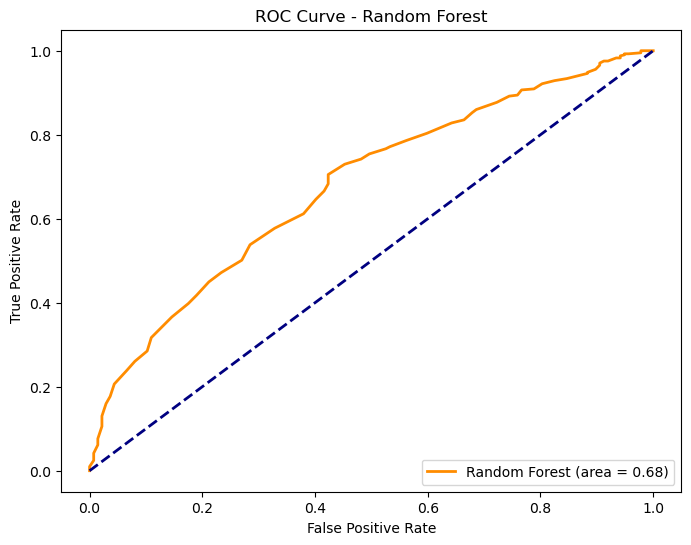

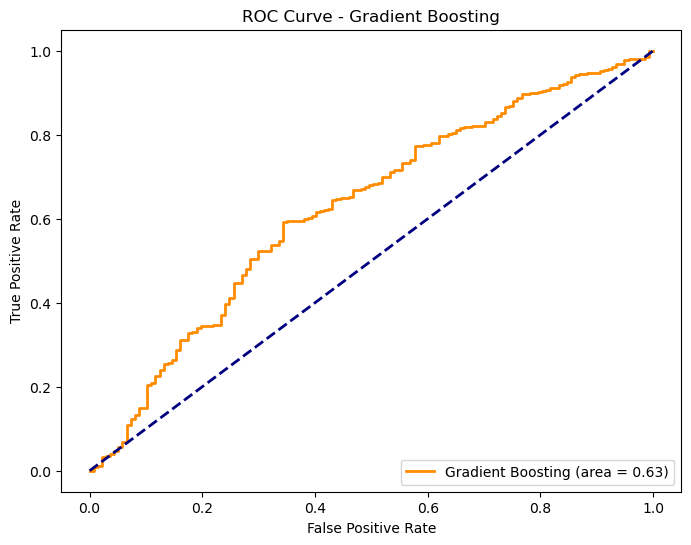

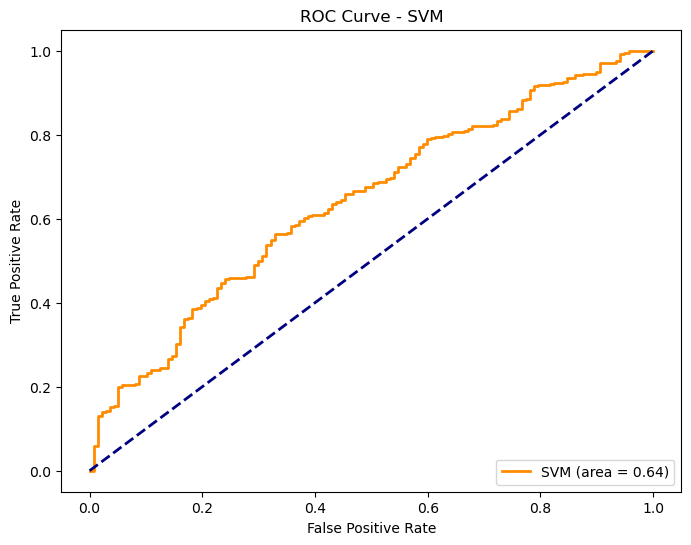

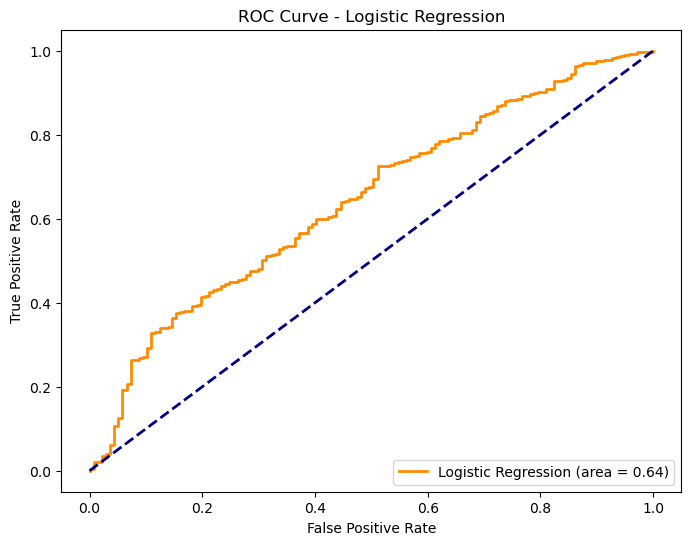

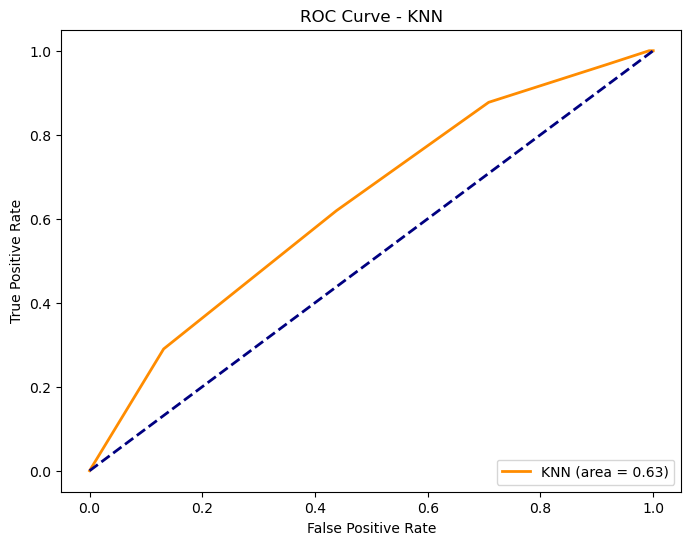

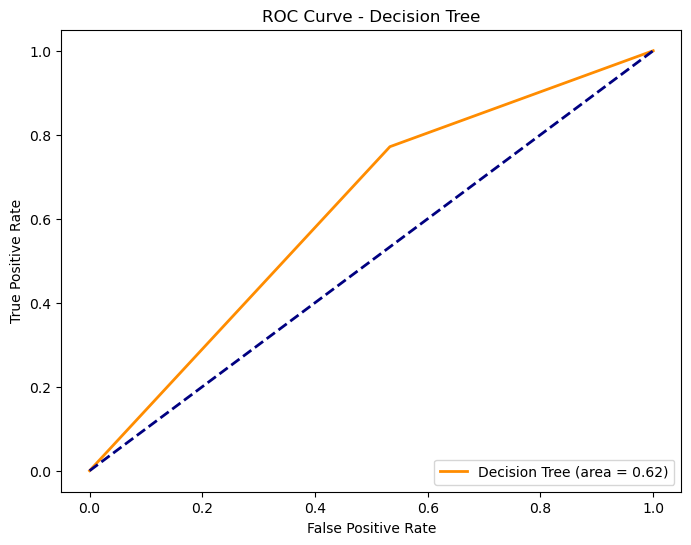

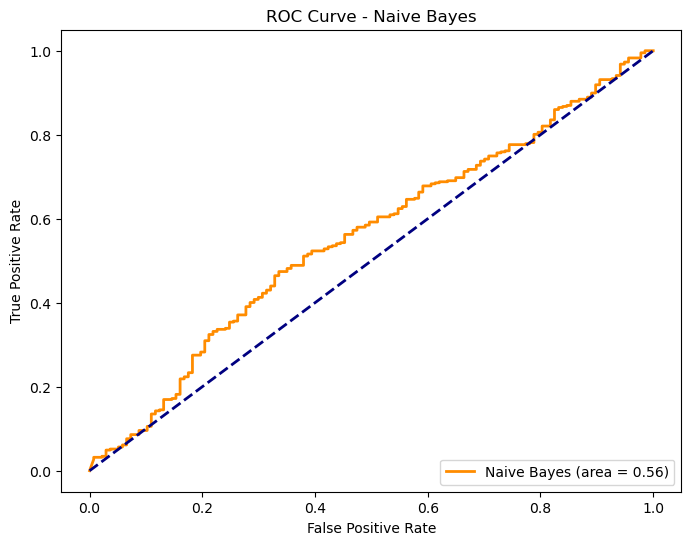

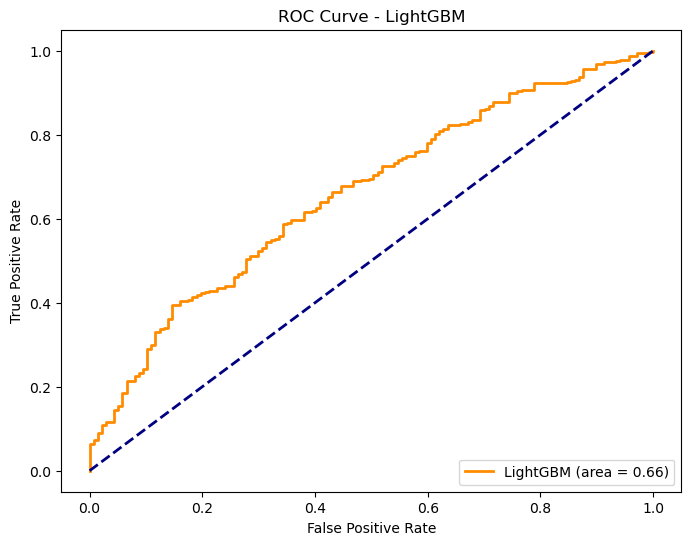

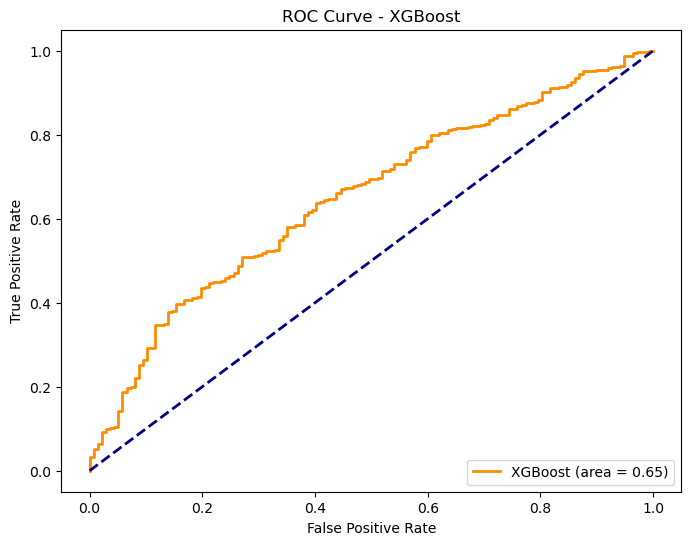

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold stratified cross-validation

for name, clf in cv_classifiers.items():
    # Get predicted probabilities for class 1 using cross-validation
    predicted_probabilities = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    
    auc_result_no_weight = {
        'Classifier':[],
        'AUC':[]
    }

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_train, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    auc_result_no_weight['Classifier'].append(name)
    auc_result_no_weight['AUC'].append(roc_auc)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')

plt.show()
auc_result_no_weight_df=pd.DataFrame(auc_result_no_weight)

hypertuning selected models

model building